In [1]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from timerun import time_code, time_func
import time
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from parallel_methods import DSMethods
from sklearn.utils import resample

In [2]:
def plot_train_vs_test(train_scores, test_scores, spoint = None, wo = None, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    
    xleft, xright = plt.xlim()
    if spoint and wo:
        plt.scatter(spoint[0], spoint[1], s=10, c='red')
        w = [-wo[1]/n_features, wo[0]]
        b = w[0]*spoint[0] + w[1]*spoint[1]
        xleft, xright = plt.xlim()
        xd = np.array([xleft, xright])
        yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
        plt.plot(xd, yd, lw=1, c='red')
    
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.xlim([xleft, xright])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)

def scal(data, w):
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    spoint_x = list(data.keys())[np.argmin(obj)]
    spoint_y = data[spoint_x]
    return (spoint_x, spoint_y, obj[np.argmin(obj)])

def mean_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.mean([data[v][x] for v in data])
    return arr

In [3]:
def plot_train_vs_test_old(train_scores, test_scores, w_scores, spoint, wpoint, wo, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    plt.plot(w_scores.keys(), w_scores.values(), label = "RFE Prediction", zorder = 0)
    
    xleft, xright = plt.xlim()
    def peano_draw(spoint, wo, color = 'red'):
        plt.scatter(spoint[0], spoint[1], s=25, c=color)
        w = [-wo[1]/n_features, wo[0]]
        b = w[0]*spoint[0] + w[1]*spoint[1]
        xd = np.array([xleft, xright])
        yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
        plt.plot(xd, yd, lw=1, c=color)

    peano_draw(spoint, wo, color='red')
    peano_draw(wpoint, wo, color='green')
    
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.xlim([xleft, xright])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    # Project wpoint (pareto optimal of stopcond prediction)
    w_y = np.interp([wpoint[0]], list(test_scores.keys()), list(test_scores.values()))
    w_obj = wo[0] * (1 - w_y) + wo[1] * (wpoint[0] / n_features)
    plt.scatter(wpoint[0], w_y[0], s=25, c='green')
    plt.vlines([wpoint[0]], 0.4, 1.0, linestyles='dashed', colors='green')

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)
    print("PREDICT AT", (wpoint[0], w_y[0], w_obj[0]))

def plot_pareto_score(data, w, point_x):
    data = {k: v for k, v in sorted(data.items(), key=lambda x: x[0])}
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    plt.plot(data.keys(), obj, label = "Pareto Score")

    print('LEL', [point_x], list(data.keys()))
    point_y = np.interp([float(point_x)], np.array(list(data.keys())), obj)
    print(point_x, point_y, obj)

    plt.scatter(point_x, point_y[0], s=25, c='green')
    plt.show()

In [4]:
n_features = 300
X, y = make_classification(n_samples = 2000, n_features = n_features, n_informative = 100, n_clusters_per_class=3, n_redundant=100, n_repeated=20, flip_y=0.05, random_state=2, class_sep=2)
X_train, X_test = np.split(X, [1000])
y_train, y_test = np.split(y, [1000])
data = DSMethods(n_features, X_train, y_train, X_test, y_test)

# Random selection

In [5]:
@time_func
def RANDOM_SELECTION(CVal = 0.1, kernel='liblinear', w1 = [0.8, 0.2]):
    data.kernel = kernel
    data.C = CVal
    with Pool(7) as pool:
        scores = pool.map(data.randomSelection, [CVal]*10)
    
    #scores = list(map(data.randomSelection, [0.1]))

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    time         = np.mean([x[2] for x in scores])
    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1)

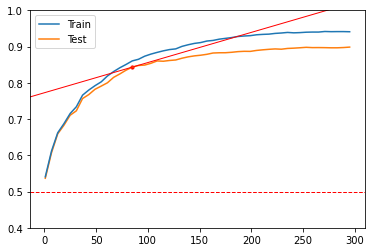

AT (85, 0.8433999999999999, 0.18194666666666673) WITH 0 ITERATIONS IN -1 SECONDS : -1
__main__.RANDOM_SELECTION - 00:00:06.791643100


In [6]:
RANDOM_SELECTION(0.00001)

# SVM-RFE

In [7]:
@time_func
def SVM_RFE_SAMPLING(step, C = 0.1, w1 = [0.8, 0.2], pstep = 0.2):
    data.C = C
    data.prevstep = pstep
    
    kf = KFold(n_splits=7, shuffle=True)

    index = [(train_index, test_index, step, w1) for train_index, test_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe_stopcond, index)

    #scores = list(map(data.svm_rfe_stopcond, index))
    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    wscores      = mean_of_arrays({i: x[4] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])
    time2        = np.mean([x[5] for x in scores])

    #wscores      = {i: x[4] for i, x in enumerate(scores)}[0]
    #cost(wscores, points, w1[0], w1[1], n_features)

    spoint = scal(test_scores, w1)
    wpoint = scal(wscores, w1)

    print(C, step, pstep)
    #plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)
    plot_train_vs_test_old(train_scores, test_scores, wscores, spoint, wpoint, w1, points, time, tvar)
    #plot_pareto_score(wscores, w1, select)

    return spoint, wpoint, time, time2

0.1 5 0.5


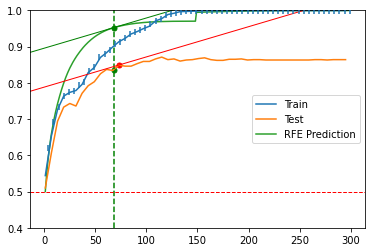

AT (73, 0.8490734617495181, 0.16940789726705216) WITH 60 ITERATIONS IN 19.962680714471 SECONDS : 8.871123022689238
PREDICT AT (68, 0.8365624985343296, 0.17608333450586963)
__main__.SVM_RFE_SAMPLING - 00:00:45.950047000


((73, 0.8490734617495181, 0.16940789726705216),
 (68, 0.9523282342022164, 0.08347074597156026),
 19.962680714471,
 1.632598945072719)

In [8]:
SVM_RFE_SAMPLING(5, 0.1, pstep=0.5)

1e-05 5 1.0


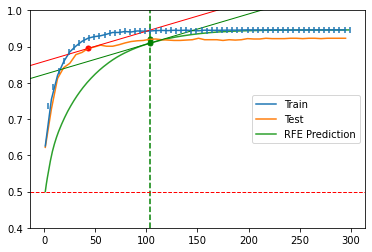

AT (43, 0.8950204724852612, 0.11265028867845774) WITH 60 ITERATIONS IN 2.276522840772356 SECONDS : 0.007240487497539311
PREDICT AT (104, 0.920181930745311, 0.1331877887370846)
__main__.SVM_RFE_SAMPLING - 00:00:07.696206600
0.0001 5 1.0


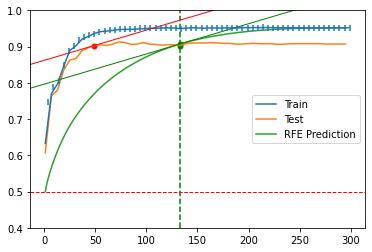

AT (49, 0.9029984100406635, 0.11026793863413586) WITH 60 ITERATIONS IN 2.90735970224653 SECONDS : 0.00938530082634993
PREDICT AT (133, 0.9030054452589663, 0.16626231045949363)
__main__.SVM_RFE_SAMPLING - 00:00:07.961222800
0.001 5 1.0


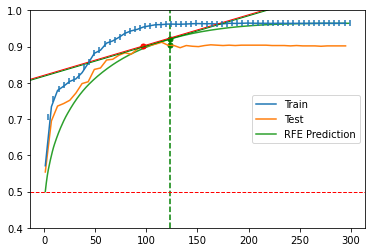

AT (97, 0.9019712681684512, 0.14308965213190572) WITH 60 ITERATIONS IN 3.0699287482670377 SECONDS : 0.020554828055178033
PREDICT AT (123, 0.9036128191057768, 0.15910974471537853)
__main__.SVM_RFE_SAMPLING - 00:00:08.438591600
0.01 5 1.0


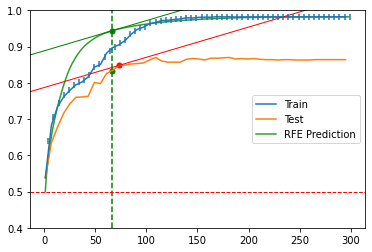

AT (73, 0.8479900381308833, 0.17027463616196006) WITH 60 ITERATIONS IN 4.4281487464904785 SECONDS : 0.0867811273357607
PREDICT AT (66, 0.8326849207130896, 0.1778520634295283)
__main__.SVM_RFE_SAMPLING - 00:00:10.976451000
0.1 5 1.0


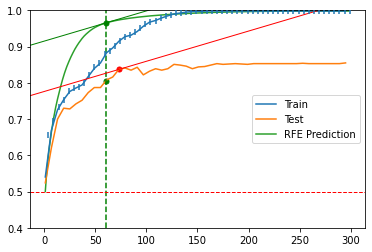

AT (73, 0.837008062360175, 0.17906021677852668) WITH 60 ITERATIONS IN 16.66713442121233 SECONDS : 4.493432075069107
PREDICT AT (60, 0.8044948009736743, 0.19640415922106055)
__main__.SVM_RFE_SAMPLING - 00:00:37.345688400
1e-05 5 0.5


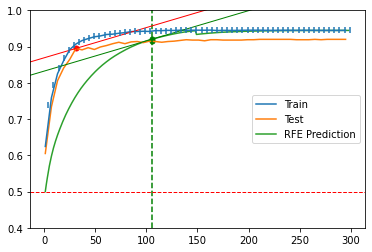

AT (31, 0.8950204724852613, 0.10465028867845765) WITH 60 ITERATIONS IN 2.070338078907558 SECONDS : 0.0026331857041589743
PREDICT AT (105, 0.9146698372050486, 0.13826413023596112)
__main__.SVM_RFE_SAMPLING - 00:00:06.668673900
0.0001 5 0.5


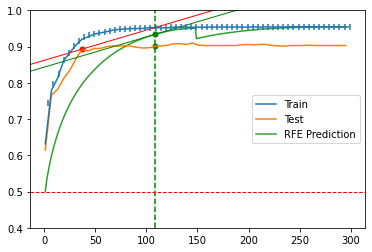

AT (37, 0.8929872943957451, 0.1102768311500706) WITH 60 ITERATIONS IN 2.8971428530556813 SECONDS : 0.004284929742773468
PREDICT AT (108, 0.9003273721583582, 0.1517381022733134)
__main__.SVM_RFE_SAMPLING - 00:00:08.021845400
0.001 5 0.5


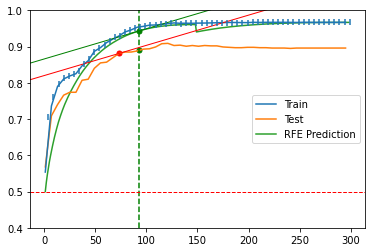

AT (73, 0.8809852119711274, 0.14387849708976472) WITH 60 ITERATIONS IN 3.1569769041878835 SECONDS : 0.02810124634201508
PREDICT AT (93, 0.8896549459929742, 0.1502760432056206)
__main__.SVM_RFE_SAMPLING - 00:00:08.938279500
0.01 5 0.5


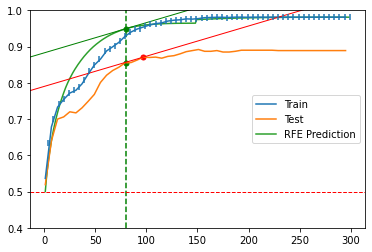

AT (97, 0.8710233428543289, 0.16784799238320353) WITH 60 ITERATIONS IN 5.253526551382882 SECONDS : 0.06871796798499445
PREDICT AT (80, 0.8552023094276615, 0.16917148579120414)
__main__.SVM_RFE_SAMPLING - 00:00:12.827886000
0.1 5 0.5


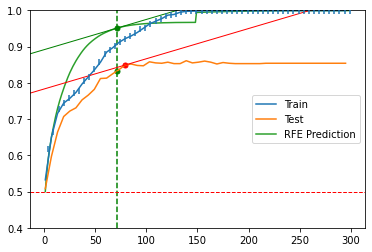

AT (79, 0.8490031095664898, 0.1734641790134748) WITH 60 ITERATIONS IN 20.553996528897965 SECONDS : 13.47550954247274
PREDICT AT (71, 0.8323155717521915, 0.18148087593158013)
__main__.SVM_RFE_SAMPLING - 00:00:46.509774300
1e-05 5 0.2


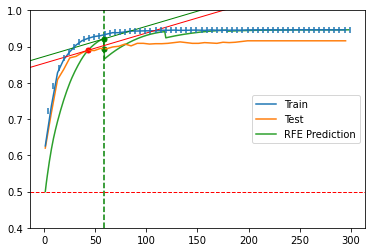

AT (43, 0.8899762209621365, 0.1166856898969575) WITH 60 ITERATIONS IN 2.2221601690564836 SECONDS : 0.004511836176329687
PREDICT AT (58, 0.8945139367674579, 0.12305551725270032)
__main__.SVM_RFE_SAMPLING - 00:00:07.117888800
0.0001 5 0.2


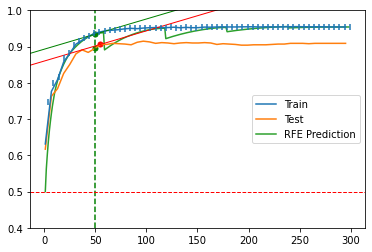

AT (55, 0.9059954130376665, 0.11187033623653346) WITH 60 ITERATIONS IN 2.87040308543614 SECONDS : 0.005986942753978912
PREDICT AT (50, 0.8959995403657377, 0.11653370104074318)
__main__.SVM_RFE_SAMPLING - 00:00:08.455208000
0.001 5 0.2


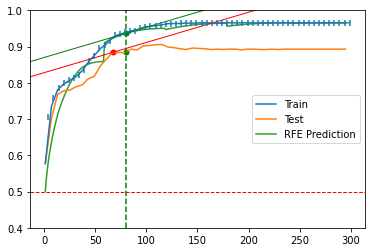

AT (67, 0.8839962854047361, 0.13746963834287781) WITH 60 ITERATIONS IN 3.329277345112392 SECONDS : 0.04379917158770491
PREDICT AT (80, 0.8846529057796665, 0.14561100870960014)
__main__.SVM_RFE_SAMPLING - 00:00:09.032746300
0.01 5 0.2


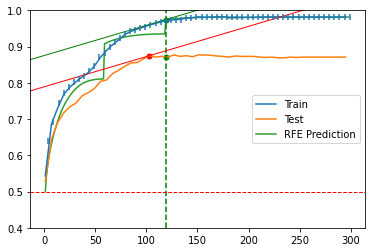

AT (103, 0.8750193468503328, 0.16865118918640043) WITH 60 ITERATIONS IN 5.015439850943429 SECONDS : 0.10795871371346391
PREDICT AT (119, 0.8716940336658647, 0.18197810640064155)
__main__.SVM_RFE_SAMPLING - 00:00:12.618740200
0.1 5 0.2


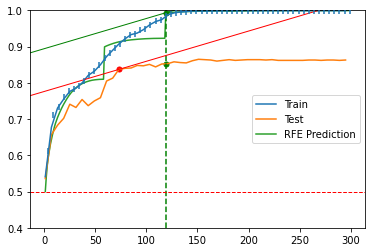

AT (73, 0.8370291680150836, 0.17904333225459976) WITH 60 ITERATIONS IN 21.317829404558456 SECONDS : 1.2972477501371427
PREDICT AT (119, 0.8526543878656555, 0.19720982304080895)
__main__.SVM_RFE_SAMPLING - 00:00:45.036849200


In [39]:
model_selection = {}
for p in [1.0, 0.5, 0.2]:
    for C in [0.00001, 0.0001, 0.001, 0.01, 0.1]:
        model_selection[C, p] = SVM_RFE_SAMPLING(5, C, pstep=p)

In [49]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.5f}".format(C) + '}', '', '', '']

for C, d in model_selection:
    col = {1: 1, 0.5: 2, 0.2: 3}
    if d in col.keys():
        v = model_selection[C, d]
        spoint = v[0][0]
        wpoint = v[1][0]
        diff = abs(spoint - wpoint) / n_features
        lines[C][col[d]] = "  {:01.0f}\\% & {:01.0f}\\% & {:01.0f}\\%".format((spoint / n_features) * 100, (wpoint / n_features) * 100, diff * 100)

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{0.00001} &   43 & 104 & 61 — 20.3\% &   31 & 105 & 74 — 24.7\% &   43 & 58 & 15 — 5.0\%\\
\textbf{0.00010} &   49 & 133 & 84 — 28.0\% &   37 & 108 & 71 — 23.7\% &   55 & 50 & 5 — 1.7\%\\
\textbf{0.00100} &   97 & 123 & 26 — 8.7\% &   73 & 93 & 20 — 6.7\% &   67 & 80 & 13 — 4.3\%\\
\textbf{0.01000} &   73 & 66 & 7 — 2.3\% &   97 & 80 & 17 — 5.7\% &   103 & 119 & 16 — 5.3\%\\
\textbf{0.10000} &   73 & 60 & 13 — 4.3\% &   79 & 71 & 8 — 2.7\% &   73 & 119 & 46 — 15.3\%\\


In [43]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.6f}".format(C) + '}', '', '', '']

for C, d in model_selection:
    col = {1: 1, 0.5: 2, 0.2: 3}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "{:.0f}:{:0>2s}.{:0>3s}".format(v[3]/60, str(int(v[3] % 60)), str(int((v[3] % 1) * 1000)))

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{0.000010} & 0:00.095 & 0:00.098 & 0:00.211\\
\textbf{0.000100} & 0:00.112 & 0:00.143 & 0:00.275\\
\textbf{0.001000} & 0:00.118 & 0:00.173 & 0:00.350\\
\textbf{0.010000} & 0:00.213 & 0:00.300 & 0:00.520\\
\textbf{0.100000} & 0:01.068 & 0:01.173 & 0:02.380\\


In [44]:
lines = {}
for C, d in model_selection:
    lines[C] = ['\\textbf{' + "{:.6f}".format(C) + '}', '', '', '']

for C, d in model_selection:
    col = {1: 1, 0.5: 2, 0.2: 3}
    if d in col.keys():
        v = model_selection[C, d]
        lines[C][col[d]] = "{:.0f}:{:0>2s}.{:0>3s}".format(v[2]/60, str(int(v[2] % 60)), str(int((v[2] % 1) * 1000)))

for line in lines.values():
    print(' & '.join(line) + '\\\\')

\textbf{0.000010} & 0:02.276 & 0:02.070 & 0:02.222\\
\textbf{0.000100} & 0:02.907 & 0:02.897 & 0:02.870\\
\textbf{0.001000} & 0:03.069 & 0:03.156 & 0:03.329\\
\textbf{0.010000} & 0:04.428 & 0:05.253 & 0:05.015\\
\textbf{0.100000} & 0:16.667 & 0:20.553 & 0:21.317\\
